<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [ ]:
# Install emojis to aid in the mapping of emojis on tweets to words
pip install emoji


In [36]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
import re


# Libraries for data preparation and model building
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.parsing.preprocessing import STOPWORDS
from comet_ml import Experiment
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from nltk.corpus import stopwords

# Setting global constants to ensure notebook results are reproducible
PARAMETER_CONSTANT = 28

In [51]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="cbtJsKjDivb61gTUBXpeo48r7",
    project_name="classification-predict-streamlit-group3",
    workspace="michael-py",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Error logging git-related information
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/michael-py/classification-predict-streamlit-group3/8b990835406f45a4915e8763ec32fd6f



<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [9]:
# Load train Data and view first five columns
df = pd.read_csv('train.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


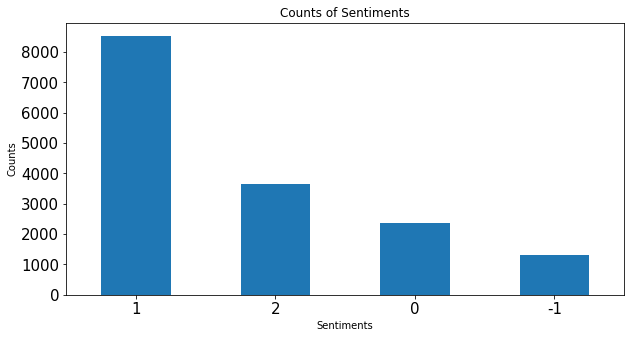

In [14]:
df['sentiment'].value_counts().plot(kind='bar',figsize=(10,5),fontsize = 15,
                                    title = 'Counts of Sentiments',
                                    legend =False, xlabel = 'Sentiments',
                                    ylabel = 'Counts', rot = 'horizontal');

### Plot Most Frequent words in Each class of sentiment

Before we go any further, lets use regular expressions to remove those non english text characters from the text distribution 

### Plot of most frequent words in each sentiment class

In [27]:
def word_cloud(data, col_name, sentiment):
    # Create a variable to store the text
    data = data[data['sentiment'] == sentiment]
    text = " ".join(word for word in data[col_name])
    # Instantiate wordcloud object
    word_cloud = WordCloud(collocations =False,
                          background_color = 'White',
                          width=400, 
                          height=300, 
                          contour_width=2, 
                          contour_color='steelblue')
    # generate wordcloud images
    word_cloud.generate(text)
    # Create Plot
    
    plt.figure(figsize =(10,10))
    plt.imshow(word_cloud, interpolation ='bilinear' )
    plt.axis('off')
    plt.title('Most Frequent Words in sentiment {}'.format(sentiment), size = 25, pad =15)
    plt.show()

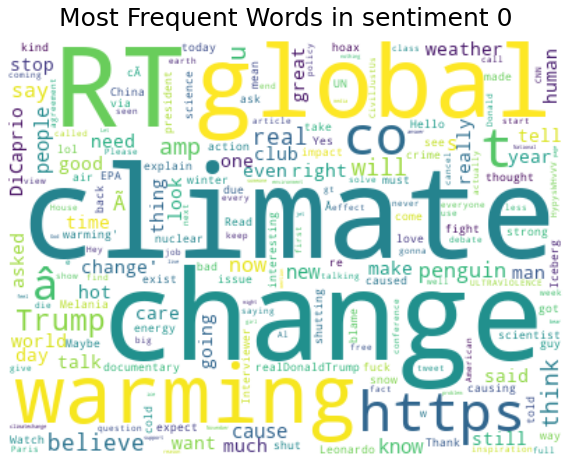

In [28]:
word_cloud(df, 'message', 0)

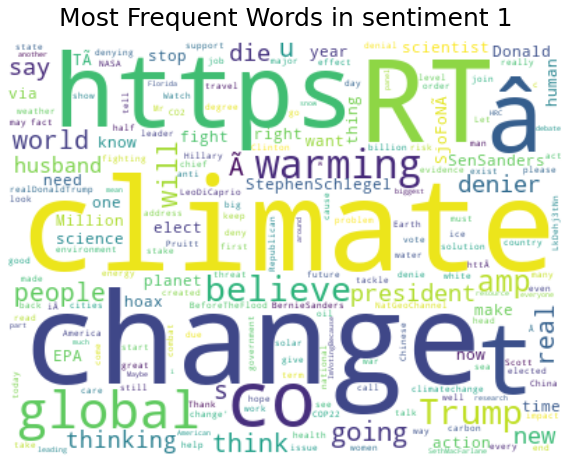

In [29]:
word_cloud(df, 'message', 1)

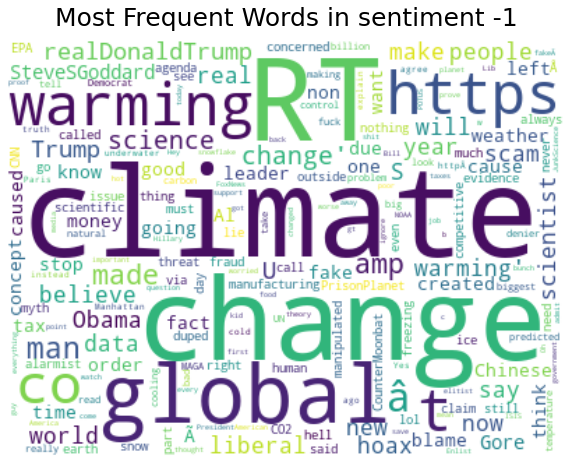

In [30]:
word_cloud(df, 'message', -1)

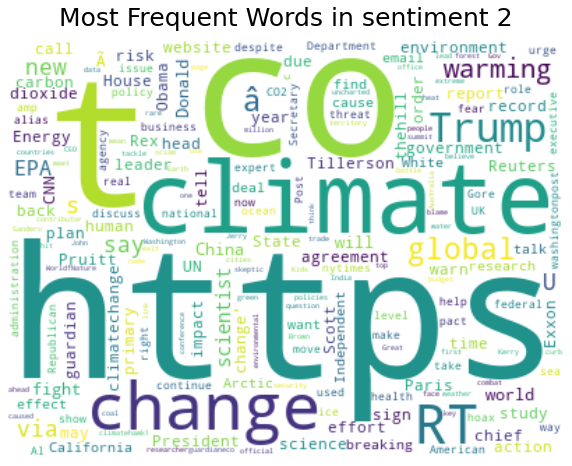

In [31]:
word_cloud(df, 'message',2)

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [32]:
# Function to extracct weblinks from the tweets
def extract_weblinks(text):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    result = re.search(pattern_url, text)
    if result is None:
        result = ''
    else:
        result = result.group()
        
    return result

In [33]:
# Function to extract the headers from each extracted weblink
def get_headers(text):
    urls = extract_weblinks(text)
    try:
        from bs4 import BeautifulSoup
        import requests
        response = requests.get(urls)
        soup = BeautifulSoup(response.text, 'html.parser')
        titles = ''
        for title in soup.find_all('title'):
            if title:
                titles = title.get_text()
    except Exception:
        return ''
    return titles

In [37]:
# Function to clean data and extract headers from weblinks
def replace_urls(text):
    import emoji
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    word = []
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    texts = re.sub(r'RT\s@\w+','retweet', text)
    texts = emoji.demojize(texts)
    for char in texts.split():
#         urls = extract_weblinks(char)
#         header = get_headers(char)
        char = re.sub(pattern_url,'', char)
        char = re.sub(r'@','', char)
        char = re.sub(r'https?[://a-zA-Z\.0-9]*','', char)
        char = re.sub(r'https?://(www\.)?(\w+)(\.\w+)',r'',char)
        char = re.sub(r'\s+$',r'',char)
        char = re.sub(r'\w\s$','',char)
        char = re.sub(r'[#,@,$_,?*//""]',r'',char)
        char = re.sub(r'(^\W+|\W+$)','',char)
        char = re.sub(r'[0-9]','',char)
        char = re.sub(r'\w\W','',char)

        word.append(char.lower())
    words = [lemmatizer.lemmatize(i) for i in word]
    
    return ' '.join(words)

In [38]:
# from sklearn.utils import shuffle
# from sklearn.utils import resample
# minus_ones = df[df['sentiment'] == -1]
# ones = df[df['sentiment'] == 1].sample(minus_ones.shape[0])
# twos = df[df['sentiment'] == 2].sample(minus_ones.shape[0])
# zeros = df[df['sentiment'] == 0].sample(minus_ones.shape[0])

In [39]:
# ones['cleaned'] = ones.message.apply(replace_urls)
# twos['cleaned'] = twos.message.apply(replace_urls)
# minus_ones['cleaned'] = minus_ones.message.apply(replace_urls)
# zeros['cleaned'] = zeros.message.apply(replace_urls)
# train = pd.concat([ones,minus_ones,twos,zeros],ignore_index = True)
# train = shuffle(train, random_state = 28)
# train['cleaned'] = train.message.apply(replace_urls)

In [40]:
# create data set and labels
df['cleaned'] = df.message.apply(replace_urls)
#documents = train['cleaned']
documents = df['message']
labels = df.sentiment
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(documents, labels,test_size=0.2 ,shuffle = True, random_state = 28)

In [41]:
df.head()

,sentiment,message,tweetid,cleaned
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doest think carbon diox...
1,1,It's not like we lack evidence of anthropogeni...,126103,is not like we lack evidence of anthropogenic ...
2,2,RT @RawStory: Researchers say we have three ye...,698562,retweet researcher say we have three year to a...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired wa a pivotal year in the ...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,retweet is and a racist sexist climate change...


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [42]:
# Hyperparam dictionary for grid search
hyper_param = {'max_depth': range(1, 15),
               'min_samples_split': range(10, 110, 10),
               'min_samples_leaf':range(0,11,2)}


stopwords = stopwords.words('english')
# create and train pipeline for 3 different models

# Try out Count Vectorizer and tfidf Vectorizer
cv = CountVectorizer(ngram_range=(1, 1))
tfidf = TfidfVectorizer(ngram_range=(1, 1))

# Create objects of randomForest, NaiveBayes and LogisticRegressiom
rf = RandomForestClassifier(n_estimators = 200, random_state = PARAMETER_CONSTANT)
lr = LogisticRegression(multi_class = 'ovr',  max_iter=5000, C = 5, random_state = PARAMETER_CONSTANT)
nb = MultinomialNB()

# Create pipeline object
pipe = Pipeline([('vectorizer', cv), ('lr',lr)])

# fit The pipeline
pipe.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(pipe.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 0.9985783384405267


<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [43]:
# Evaluate the model on the test set
f1score = f1_score(y_test, pipe.predict(x_test), average ='weighted')
precision = precision_score(y_test, pipe.predict(x_test), average ='weighted')
recall = recall_score(y_test, pipe.predict(x_test), average ='weighted')

print("the f1score is: {}".format(f1score))
print("the precission is: {}".format(precision))
print("the recall is: {}".format(recall))

the f1score is: 0.7542330956611362
the precission is: 0.7541377540736709
the recall is: 0.7604298356510746


In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

<a id="seven"></a>
## 8. Kaggle Submission
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Kaggle Submission ⚡ |
| :--------------------------- |
|  |

---

In [44]:
# Load Test data for Kaggle submission
test = pd.read_csv('test.csv')

In [47]:
# Create sample submission file
sample = test[['tweetid']]
sample['sentiment'] = 0

In [48]:
# Append the predictions to the sample prediction file
sample['sentiment'] = pipe.predict(test.message)
sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
# Save the submission file as a csv
sample.to_csv('Logistic_Regression.csv', index = False)

<a id="seven"></a>
## 9. Log Parameter on Comet
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
|  |

---

In [52]:
# Create dictionaries for the data we want to log

  
params = {"random_state": 28,
          "model_type": "logreg",
          "multi_class": 'ovr',
          "max_iter": 5000,
           "C": 5
          }
metrics = {"f1score": f1score,
           "recall": recall,
           "precision": precision
           }

In [53]:
# Log parameters and metrics
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [54]:
# discuss chosen methods logic
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/michael-py/classification-predict-streamlit-group3/8b990835406f45a4915e8763ec32fd6f
COMET INFO:   Metrics:
COMET INFO:     f1score   : 0.7542330956611362
COMET INFO:     precision : 0.7541377540736709
COMET INFO:     recall    : 0.7604298356510746
COMET INFO:   Parameters:
COMET INFO:     C            : 5
COMET INFO:     max_iter     : 5000
COMET INFO:     model_type   : logreg
COMET INFO:     multi_class  : ovr
COMET INFO:     random_state : 28
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages     